In [1]:
import matplotlib.pyplot as plt
import numpy as np
# plt.style.use('_mpl-gallery')
import pandas as pd
import os
from matplotlib.colors import Normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import torch as T
import torch.linalg as LA
import os

In [2]:

class LID_processer:
    def __init__(self, LID_eval):
        self.LID_eval = T.tensor(LID_eval)
        self.grid = int(np.sqrt(LID_eval.shape[0]))
        
    @staticmethod
    def process_results(LID_eval, mode='TV', threshold=0.95):
        if mode == 'TV':
            # how many dimensions are needed to explain 95% of the variance    
            cumsum = T.cumsum(LID_eval, dim=1)
            LID_eval = (cumsum < threshold).sum(dim=1) + 1
        elif mode == 'MV':
            ## number of dimnesions larger than 5% of the variance
            print(LID_eval)
            LID_eval = (LID_eval >= (1-threshold)).sum(dim=1) 
            # print(LID_eval)
        elif mode == 'VR':
            ## compute the variance ratio
            delta_v = LID_eval[:, ] - T.concatenate((LID_eval[:, 1:], T.zeros((LID_eval.shape[0], 1))), dim=1)
            total_dv = T.sum(delta_v, dim=1)
            norm_delta_v = delta_v/total_dv.reshape(-1, 1)
            cumsum = T.cumsum(norm_delta_v, dim=1)
            LID_eval = (cumsum < threshold).sum(dim=1) + 1
            
        elif mode == 'percent':
            LID_eval = T.sum(LID_eval[:, :2], dim=1)
        else:
            raise ValueError('mode should be either dim or percent')
        return LID_eval           

    def plot_LID(self,  ax=None,  cmap='jet', mode='dim', threshold=0.95, prerun=False, range=None):
        LID_map = self.process_results(self.LID_eval, mode, threshold)
        LID_map = LID_map.reshape(self.grid, self.grid).to('cpu').numpy()

        map = np.flip(LID_map, axis=0)
        if prerun:
            return (map.min(), map.max())        

        if ax is None:
            # cbar of this plot
            if mode == 'percent':
                image = plt.imshow(map, cmap=cmap, norm=MidpointNormalize(midpoint=0.95, vmax=1)) 
                # continuous colorbar
                # plt.colorbar(image)
            else:
                self.discrete_matshow(map, cmap=cmap)

   
            # not show the ticks
            plt.xticks([])
            plt.yticks([])

        else:
            ax.set_xticks([])
            ax.set_yticks([])
            if mode == 'percent':
                # continuous colorbar
                # image = ax.imshow(map, cmap=cmap, norm=MidpointNormalize(midpoint=0.95, vmax=1))
                if range is not None:
                    image = ax.imshow(map, cmap=cmap, vmin=range[0], vmax=range[1])
                else:
                    image = ax.imshow(map, cmap=cmap, norm=MidpointNormalize(midpoint=0.95, vmax=1))
                # plt.colorbar(image, ax=ax)
                average = np.mean(map)
                ax.text(0.78, 0.05, f'{average:.2f}', color='k', transform=ax.transAxes, fontsize=12)
            else:
                # discrete colorbar
                if range is not None:
                    image = self.discrete_matshow(map, cmap=cmap, ax=ax, range=range)
                else:
                    image = self.discrete_matshow(map, cmap=cmap, ax=ax)
                average = np.mean(map)
                # ax.set_title(f'Average LID: {average:.2f}')
                ax.text(0.78, 0.05, f'{average:.2f}', color='w', transform=ax.transAxes, fontsize=12)

        return image
        

    @staticmethod     
    def discrete_matshow(data, cmap, ax=None, range=None):
    # get discrete colormap
        if range is not None:
            cmap = plt.get_cmap(cmap, range[1] - range[0] + 1)
        else:
            cmap = plt.get_cmap(cmap, np.max(data) - np.min(data) + 1)
        # set limits .5 outside true range
        if ax is None:
            if range is not None:
                mat = plt.imshow(data, cmap=cmap, vmin=range[0], vmax=range[1])
            else:
                mat = plt.imshow(data, cmap=cmap, vmin=np.min(data) - 0.5, 
                            vmax=np.max(data) + 0.5)
            # tell the colorbar to tick at integers
            cax = plt.colorbar(mat, ticks=np.arange(np.min(data), np.max(data) + 1))
        else:
            if range is not None:
                mat = ax.imshow(data, cmap=cmap, vmin=range[0], vmax=range[1])
            else:
                mat = ax.imshow(data, cmap=cmap, vmin=np.min(data) - 0.5, 
                            vmax=np.max(data) + 0.5)
            
            # tell the colorbar to tick at integers
            fig = ax.get_figure()
            # cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
            # plt.colorbar(mat,  ticks=np.arange(np.min(data), np.max(data) + 1))
            return mat
            
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y)) 



def plot_prob_map(labels, alpha, X_2d, y, ax=None, cmap=cm.tab10, epsilo=0.85, proba=True, ture_map=False, ):
    """Plot probability map for the classifier
    """

    n_class_max = max(labels)
    labels_normlized = labels/n_class_max
    map = cmap(labels_normlized)
    if proba:
        map[:, 3] = alpha 
    map[:, 3] *= epsilo  # plus a float to control the transparency
    grid = int(np.sqrt(labels.shape[0]))
    map =  map.reshape(grid, grid, 4)
    map = np.flip(map, 0)
    ax.imshow(map, interpolation='nearest', aspect='equal', extent=[0, 1, 0, 1])
    ax.set_facecolor('black')
    ax.set_xticks([])
    ax.set_yticks([])
    # set lim
    # ax.set_xlim(xx.min(), xx.max())
    # ax.set_ylim(yy.min(), yy.max())
    X_2d_scaled = MinMaxScaler().fit_transform(X_2d)
    ax.scatter(X_2d_scaled[:, 0], X_2d_scaled[:, 1], c=y, s=0.5, alpha=0.8, cmap=cmap, edgecolors='k', linewidths=0.1)

    return ax

def plot_GM(D):
    gird = int(np.sqrt(D.shape[0]))
    D = D.reshape(gird, gird)
    D = np.flip(D, axis=0)
    plt.imshow(D, cmap='jet')

In [3]:
# def plot_LID(dir, threshold=0.99, title=None):
#     DBM = np.load(dir + 'DBM_orig_torch.npz')
#     SDBM = np.load(dir + 'SSNP.npz')
#     DV = np.load(dir + 'DeepView_0.65.npz')
#     proj_name = ['DBM', 'SDBM', 'DV']
#     proj = [DBM, SDBM, DV]
#     row_names = ['Decsion Map', 'Local Intrinsic Dimensionality\n Axes needed to explain 99% variance', 'variance explained by the first 2 PCs']

#     fig, axes = plt.subplots(3, 3, figsize=(9, 10))

#     row1_min, row1_max = 1, 0
#     row2_min, row2_max = 1, 0
#     for j, ax_col in enumerate(axes.T):
        
#         for i, ax in enumerate(ax_col):
#             if j == 0:
#                 ax.set_ylabel(row_names[i])
#             if i == 0:
#                 ax.set_title(proj_name[j])
            
#             if i == 0:
#                 ax = plot_prob_map(proj[j]['labels'], proj[j]['alpha'], proj[j]['X_train_2d'], proj[j]['y_train'], ax=ax, epsilo=0.85, proba=True)
#             else:
#                 LID_holder = LID_processer(proj[j]['LID_evalues'])
#                 if i == 1:
#                     curmin, curmax=  LID_holder.plot_LID(ax=ax, mode='dim', threshold=threshold)
#                     row1_min = min(row1_min, curmin)
#                     row1_max = max(row1_max, curmax)
#                 elif i == 2:
#                     curmin, curmax = LID_holder.plot_LID(ax=ax, mode='percent', cmap='cividis', threshold=threshold)
#                     row2_min = min(row2_min, curmin)
#                     row2_max = max(row2_max, curmax)

#     ## set the same colorba

#     # plt.tight_layout()
#     fig.subplots_adjust(wspace=0.1, hspace=0.1)
#     if title is not None:
#         fig.suptitle(title, fontsize=16)
#     return fig
                


def plot_LID2(dir, threshold=0.95, title=None, mode1='MV'):
    DBM = np.load(dir + 'DBM.npz')
    UMAP_iLAMP = np.load(dir + 'UMAP+iLAMP.npz')
    UMAP_RBF = np.load(dir + 'UMAP+RBF.npz')
    SDBM = np.load(dir + 'SDBM.npz')
    DV = np.load(dir + 'DeepView.npz', allow_pickle=True)
    proj_name = ['DBM (UMAP+NNinv)', 'SDBM', 'DeepView','UMAP+iLAMP', 'UMAP+RBF' ]
    proj = [DBM, SDBM, DV, UMAP_iLAMP, UMAP_RBF]
    row_names = ['Decsion Map', 'Estimated ID', 'Percentage of variance \naccounted for by the first 2 PCs', 'Gradient Map']

    fig, axes = plt.subplots(4, 5, figsize=(12.9, 10.4))
    minmax = {'row1': [2, 1], 'row2': [2, 1], 'row3': [2, 1], 'row4': [1, 0], 'row5': [1, 0], 'row6': [1, 0]}
    for j, ax_col in enumerate(axes.T):
        for i, ax in enumerate(ax_col):
            if i == 0:
                # ax = plot_prob_map(proj[j]['labels'], proj[j]['alpha'], proj[j]['X_train_2d'], proj[j]['y_train'], ax=ax, epsilo=0.85, proba=True)
                pass
            else:
                LID_holder = LID_processer(proj[j]['LID_evalues'])
                if i == 1:
                    curmin, curmax =  LID_holder.plot_LID(ax=ax, mode=mode1, threshold=threshold, prerun=True)
                    # update the minmax
                    minmax[f'row{i}'][0] = min(minmax[f'row{i}'][0], curmin)
                    minmax[f'row{i}'][1] = max(minmax[f'row{i}'][1], curmax)
                elif i == 2:
                    curmin, curmax = LID_holder.plot_LID(ax=ax, mode='percent', cmap='cividis', threshold=threshold, prerun=True)
                    minmax[f'row{i}'][0] = min(minmax[f'row{i}'][0], curmin)
                    minmax[f'row{i}'][1] = max(minmax[f'row{i}'][1], curmax)

    
    for j, ax_col in enumerate(axes.T):
        for i, ax in enumerate(ax_col):
            if j == 0:
                ax.set_ylabel(row_names[i], rotation=90, ha='center', va='center')
                ax.yaxis.set_label_coords(-0.1, 0.5)
            if i == 0:
                ax.set_title(proj_name[j])
            
            if i == 0:
                ax = plot_prob_map(proj[j]['labels'], proj[j]['alpha'], proj[j]['X_train_2d'], proj[j]['y_train'], ax=ax, epsilo=0.85, proba=True)
            else:
                LID_holder = LID_processer(proj[j]['LID_evalues'])

                if i == 2:

                    ax = LID_holder.plot_LID(ax=ax, mode='percent', cmap='cividis', threshold=threshold, range=minmax[f'row{i}'])

                    if j == len(proj) - 1:
                        norm = colors.Normalize(vmin=minmax[f'row{i}'][0], vmax=minmax[f'row{i}'][1])

                        # print(minmax[f'row{i}'][0], minmax[f'row{i}'][1])
                        # cbar_dbm = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=minmax[f'row{i}'][0], vmax=minmax[f'row{i}'][1]), cmap='cividis'), ax=axes[i,:], orientation='vertical', shrink=0.9, aspect=20, pad=0.3, location='right')

                        # cbar_dbm.ax.tick_params(labelsize=8)
                        # cbar_dbm.ax.set_title('alpha', fontsize=8)
                        # set location of the colorbar  
                 
                        # cbar_ax = fig.add_axes([0.92, 0.3875, 0.01, 0.215])  # Specify position and size [0.92, 0.125, 0.01, 0.215]
                        
                        cbar_ax = fig.add_axes([0.904, 0.308, 0.006, 0.18])  # Specify position and size [0.92, 0.125, 0.01, 0.215]
                        cbar_dbm = fig.colorbar(ax, cax=cbar_ax)
                elif i == 1:
                    LID_holder.plot_LID(ax=ax, mode=mode1, threshold=threshold, range=minmax[f'row{i}'])

                    if j == len(proj) - 1:
                        vmin = minmax[f'row{i}'][0]
                        vmax = minmax[f'row{i}'][1]
                        # print(vmin, vmax)
                        cmap = plt.get_cmap('jet', vmax - vmin + 1)
                        f, a = plt.subplots(1, 1, figsize=(1, 5))
                        mat = a.imshow(np.array([[vmin, vmax]]), cmap=cmap, vmin=vmin-0.5, vmax=vmax+0.5)
                        cbar_ax = fig.add_axes([0.904, 0.501, 0.006, 0.18]) #
                        # cax = fig.colorbar(mat, ticks=np.arange(vmin, vmax + 1), cax=cbar_ax)
                        ticks = np.arange(vmin, vmax + 1)
                        # check if the ticks are too many, if so, reduce and make it intager
                        while len(ticks) > 10:
                            ticks = ticks[::2]
                        
                        cbar_dbm = fig.colorbar(mat, ticks=ticks, cax=cbar_ax)
                        

                elif i == 3:
                    GM = proj[j]['GM']
                    GM = GM.reshape(int(np.sqrt(GM.shape[0])), int(np.sqrt(GM.shape[0])))
                    GM = np.flip(GM, axis=0)
                    g_min = GM.min()
                    g_max = GM.max()
                    im = ax.imshow(GM, cmap='magma', vmin=g_min, vmax=g_max)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    ax.text(0.95, 0.04, f'{GM.mean():.2f}', ha='right', va='bottom', fontsize=12, color='white', transform=ax.transAxes)

                    ## get location of ax so that we can put the colorbar
                    ax_loc = ax.get_position()
                    print(ax_loc)
                    # colorbar for each
                    numb_cols = len(proj_name)
                    cbar_ax = fig.add_axes([ax_loc.x0 - 0.0048 * j +0.0005 , ax_loc.y0-0.012, ax_loc.width + 0.018, 0.007])
                    # fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.0461, pad=0.01, cax=cbar_ax)
                    fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
            
               



        

    # plt.tight_layout()
    fig.subplots_adjust(wspace=0.02, hspace=0.02)
    if title is not None:
        fig.suptitle(title, fontsize=16, y=0.93)
    # plt.tight_layout()
    return fig

In [15]:
mode = 'MV'
save = True
threshold = 0.99

tensor([[6.9889e-01, 3.0015e-01, 7.6853e-04,  ..., 1.2058e-06, 1.5556e-07,
         1.0364e-07],
        [7.0049e-01, 2.9853e-01, 7.6381e-04,  ..., 1.2592e-06, 1.7448e-07,
         9.9839e-08],
        [6.8312e-01, 3.1578e-01, 8.7990e-04,  ..., 1.2726e-06, 1.9282e-07,
         1.0279e-07],
        ...,
        [7.6910e-01, 2.3066e-01, 1.6472e-04,  ..., 3.7295e-07, 1.2428e-07,
         5.4728e-08],
        [7.6486e-01, 2.3492e-01, 1.5877e-04,  ..., 3.3618e-07, 1.4236e-07,
         5.2098e-08],
        [7.6907e-01, 2.3072e-01, 1.4065e-04,  ..., 3.2718e-07, 1.4391e-07,
         5.0110e-08]], dtype=torch.float64)
tensor([[7.9520e-01, 2.0474e-01, 2.5339e-05,  ..., 6.2171e-07, 4.6817e-07,
         1.9600e-07],
        [7.8959e-01, 2.1036e-01, 2.3624e-05,  ..., 6.5495e-07, 4.9497e-07,
         1.7993e-07],
        [7.9074e-01, 2.0921e-01, 2.1617e-05,  ..., 6.2214e-07, 5.0820e-07,
         2.0834e-07],
        ...,
        [7.7773e-01, 2.2165e-01, 3.7421e-04,  ..., 4.4079e-06, 3.1477e-06,
    

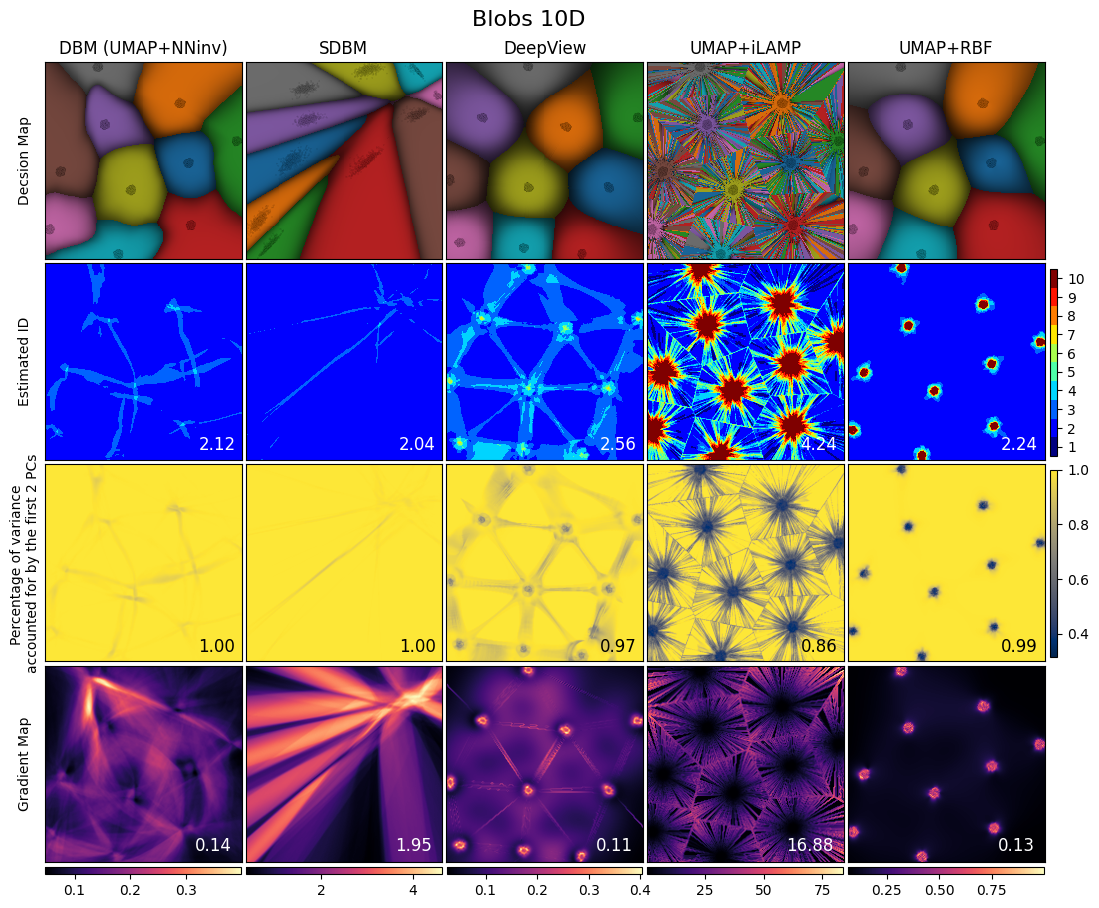

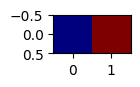

In [16]:
path = 'LID_results_new_grid500_GM/blobs_dim10_n5000_y10_'
test = plot_LID2(path, threshold=threshold, title='Blobs 10D', mode1=mode)
# plt.tight_layout()

# test.savefig('figures/blobs_dim10_n5000_y10_.png', dpi=300, bbox_inches='tight')
if save:
    test.savefig('../paper/IVAPP24_extend_CCIS/figures/figure_CCIS/blobs_dim10_id_5cols.png', dpi=300, bbox_inches='tight')
# test.savefig('../paper/PAPER_intrinsic_dim/figures/blobs_dim10_id.pdf', dpi=300, bbox_inches='tight')

tensor([[7.7906e-01, 2.2083e-01, 8.5951e-05,  ..., 5.4132e-09, 5.4055e-09,
         5.3866e-09],
        [7.6808e-01, 2.3180e-01, 9.3332e-05,  ..., 5.5095e-09, 5.4798e-09,
         5.4700e-09],
        [7.7030e-01, 2.2958e-01, 9.6576e-05,  ..., 5.4517e-09, 5.4262e-09,
         5.4183e-09],
        ...,
        [7.5911e-01, 2.4079e-01, 6.8497e-05,  ..., 5.0479e-09, 5.0130e-09,
         4.9771e-09],
        [7.6657e-01, 2.3333e-01, 6.1529e-05,  ..., 4.9230e-09, 4.9094e-09,
         4.8741e-09],
        [7.7014e-01, 2.2977e-01, 5.7907e-05,  ..., 4.8786e-09, 4.8514e-09,
         4.8063e-09]], dtype=torch.float64)
tensor([[6.6624e-01, 3.3358e-01, 1.2291e-04,  ..., 1.6514e-08, 1.1390e-08,
         8.5172e-09],
        [7.1275e-01, 2.8704e-01, 1.4731e-04,  ..., 1.6075e-08, 1.0776e-08,
         8.5336e-09],
        [6.9142e-01, 3.0838e-01, 1.3216e-04,  ..., 1.7250e-08, 1.1118e-08,
         8.4213e-09],
        ...,
        [7.7471e-01, 2.2524e-01, 1.7821e-05,  ..., 1.9902e-08, 1.5063e-08,
    

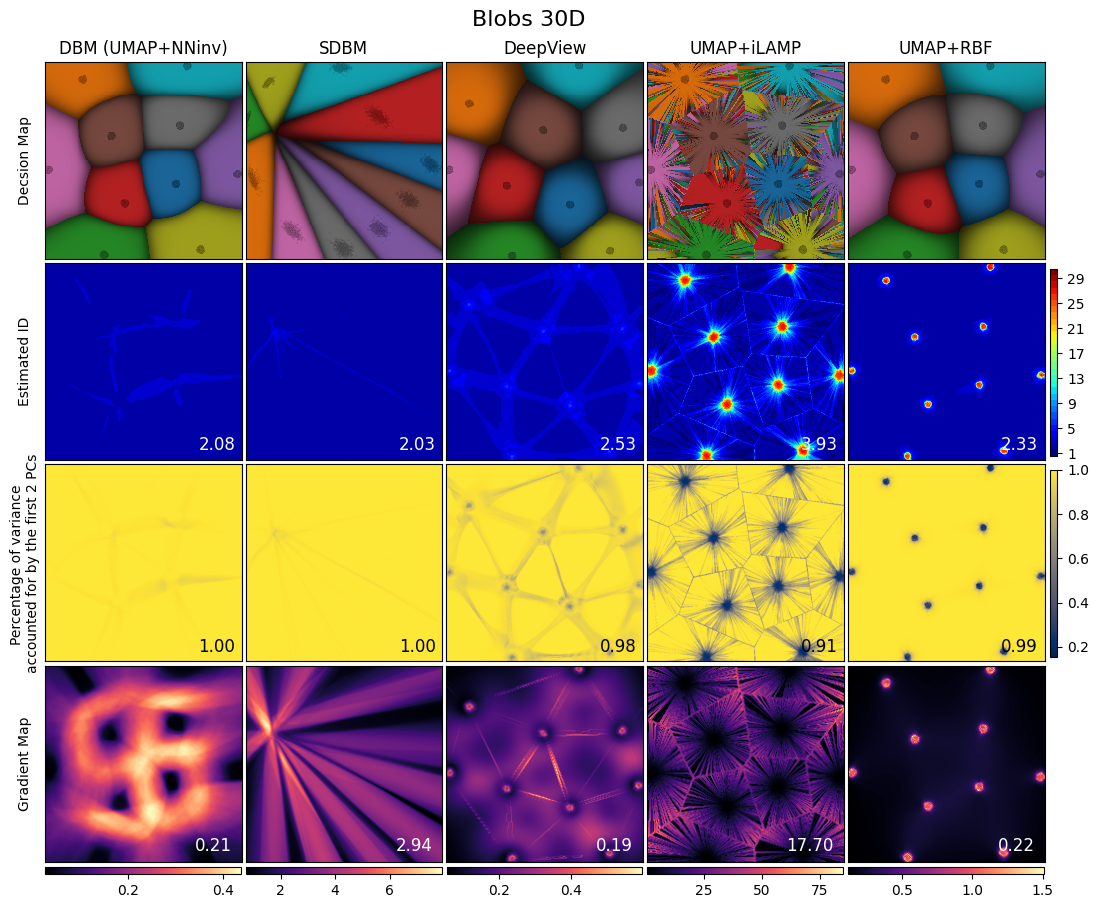

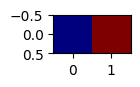

In [17]:
path = 'LID_results_new_grid500_GM/blobs_dim30_n5000_y10_'
test = plot_LID2(path, threshold=threshold, title='Blobs 30D', mode1=mode)
# plt.tight_layout()
# test.savefig('figures/blobs_dim30_n5000_y10_.png', dpi=300, bbox_inches='tight')
# test.savefig('../paper/PAPER_intrinsic_dim/figures/blobs_dim30_id.pdf', dpi=300, bbox_inches='tight')
if save:
    test.savefig('../paper/IVAPP24_extend_CCIS/figures/figure_CCIS/blobs_dim30_id_5cols.png', dpi=300, bbox_inches='tight')

tensor([[7.9401e-01, 2.0564e-01, 3.2722e-04,  ..., 2.0357e-09, 2.0357e-09,
         2.0356e-09],
        [7.7546e-01, 2.2417e-01, 3.5458e-04,  ..., 2.0917e-09, 2.0915e-09,
         2.0914e-09],
        [7.8650e-01, 2.1316e-01, 3.2745e-04,  ..., 2.0411e-09, 2.0410e-09,
         2.0409e-09],
        ...,
        [7.8547e-01, 2.1448e-01, 3.1024e-05,  ..., 9.5076e-10, 9.5075e-10,
         9.5060e-10],
        [7.7650e-01, 2.2344e-01, 3.9628e-05,  ..., 9.6704e-10, 9.6700e-10,
         9.6699e-10],
        [7.8424e-01, 2.1571e-01, 3.9969e-05,  ..., 9.6178e-10, 9.6176e-10,
         9.6175e-10]], dtype=torch.float64)
tensor([[5.3637e-01, 4.6347e-01, 6.7763e-05,  ..., 8.5661e-10, 8.5419e-10,
         8.4016e-10],
        [5.3998e-01, 4.5986e-01, 6.5934e-05,  ..., 8.5744e-10, 8.5328e-10,
         8.4209e-10],
        [5.5399e-01, 4.4586e-01, 6.5918e-05,  ..., 8.6492e-10, 8.5977e-10,
         8.5115e-10],
        ...,
        [7.6302e-01, 2.3672e-01, 1.7863e-04,  ..., 1.8916e-09, 1.6445e-09,
    

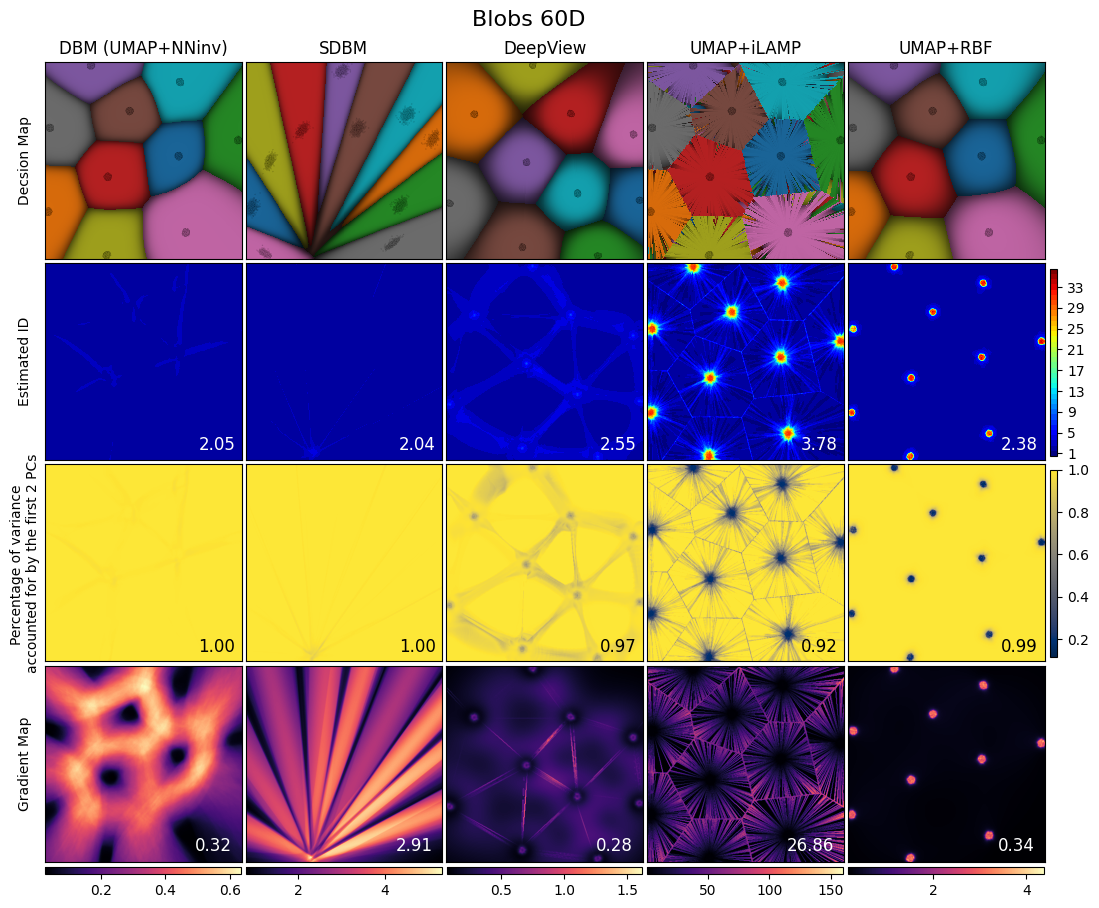

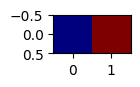

In [18]:
path = 'LID_results_new_grid500_GM/blobs_dim60_n5000_y10_'
test = plot_LID2(path, threshold=threshold, title='Blobs 60D', mode1=mode)
# plt.tight_layout()
# test.savefig('figures/blobs_dim100_n5000_y10_.png', dpi=300, bbox_inches='tight')
# test.savefig('../paper/PAPER_intrinsic_dim/figures/blobs_dim100_id.pdf', dpi=300, bbox_inches='tight')
if save:
    test.savefig('../paper/IVAPP24_extend_CCIS/figures/figure_CCIS/blobs_dim60_id_5cols.png', dpi=300, bbox_inches='tight')

tensor([[7.7442e-01, 2.2532e-01, 2.3061e-04,  ..., 1.6616e-09, 1.6616e-09,
         1.6616e-09],
        [7.6779e-01, 2.3197e-01, 2.0947e-04,  ..., 1.6727e-09, 1.6727e-09,
         1.6727e-09],
        [7.7564e-01, 2.2416e-01, 1.7788e-04,  ..., 1.6283e-09, 1.6283e-09,
         1.6283e-09],
        ...,
        [7.8201e-01, 2.1794e-01, 4.1439e-05,  ..., 1.4541e-09, 1.4541e-09,
         1.4541e-09],
        [7.7900e-01, 2.2094e-01, 4.1499e-05,  ..., 1.4822e-09, 1.4822e-09,
         1.4822e-09],
        [7.9066e-01, 2.0929e-01, 3.6677e-05,  ..., 1.4556e-09, 1.4556e-09,
         1.4556e-09]], dtype=torch.float64)
tensor([[7.0890e-01, 2.8256e-01, 8.0204e-03,  ..., 1.6733e-09, 1.6728e-09,
         1.6727e-09],
        [7.1562e-01, 2.7626e-01, 7.5943e-03,  ..., 1.6653e-09, 1.6652e-09,
         1.6646e-09],
        [7.1815e-01, 2.7410e-01, 7.2097e-03,  ..., 1.6562e-09, 1.6559e-09,
         1.6558e-09],
        ...,
        [7.2240e-01, 2.7652e-01, 9.4416e-04,  ..., 1.6637e-09, 1.6637e-09,
    

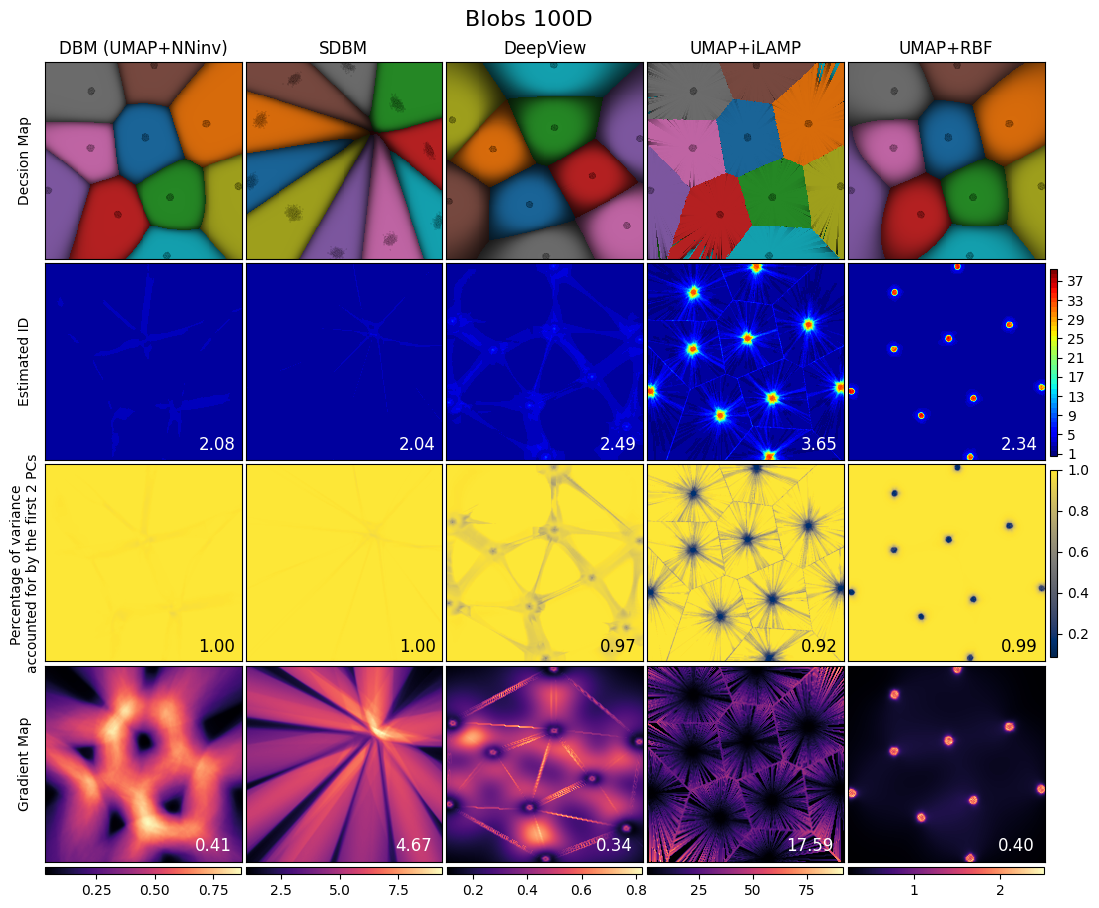

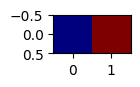

In [19]:
path = 'LID_results_new_grid500_GM/blobs_dim100_n5000_y10_'
test = plot_LID2(path, threshold=threshold, title='Blobs 100D', mode1=mode)
# plt.tight_layout()
# test.savefig('figures/blobs_dim100_n5000_y10_.png', dpi=300, bbox_inches='tight')
# test.savefig('../paper/PAPER_intrinsic_dim/figures/blobs_dim100_id.pdf', dpi=300, bbox_inches='tight')
if save:
    test.savefig('../paper/IVAPP24_extend_CCIS/figures/figure_CCIS/blobs_dim100_id_5cols.png', dpi=300, bbox_inches='tight')

tensor([[7.2077e-01, 2.7741e-01, 1.2875e-03,  ..., 2.0031e-11, 2.0031e-11,
         2.0031e-11],
        [7.2550e-01, 2.7238e-01, 1.5882e-03,  ..., 1.9924e-11, 1.9924e-11,
         1.9924e-11],
        [7.1736e-01, 2.8024e-01, 1.9043e-03,  ..., 2.0048e-11, 2.0048e-11,
         2.0048e-11],
        ...,
        [7.7575e-01, 2.2336e-01, 4.1928e-04,  ..., 5.4349e-11, 5.4349e-11,
         5.4349e-11],
        [7.6985e-01, 2.2925e-01, 4.1312e-04,  ..., 5.5090e-11, 5.5090e-11,
         5.5090e-11],
        [7.7371e-01, 2.2543e-01, 4.0262e-04,  ..., 5.5079e-11, 5.5079e-11,
         5.5078e-11]], dtype=torch.float64)
tensor([[7.7886e-01, 2.2023e-01, 6.9534e-04,  ..., 2.5273e-10, 2.5273e-10,
         2.5273e-10],
        [7.7142e-01, 2.2782e-01, 5.4535e-04,  ..., 2.5159e-10, 2.5159e-10,
         2.5159e-10],
        [7.6661e-01, 2.3278e-01, 3.9928e-04,  ..., 2.4951e-10, 2.4951e-10,
         2.4951e-10],
        ...,
        [7.5944e-01, 2.4031e-01, 4.8962e-05,  ..., 2.6870e-10, 2.6870e-10,
    

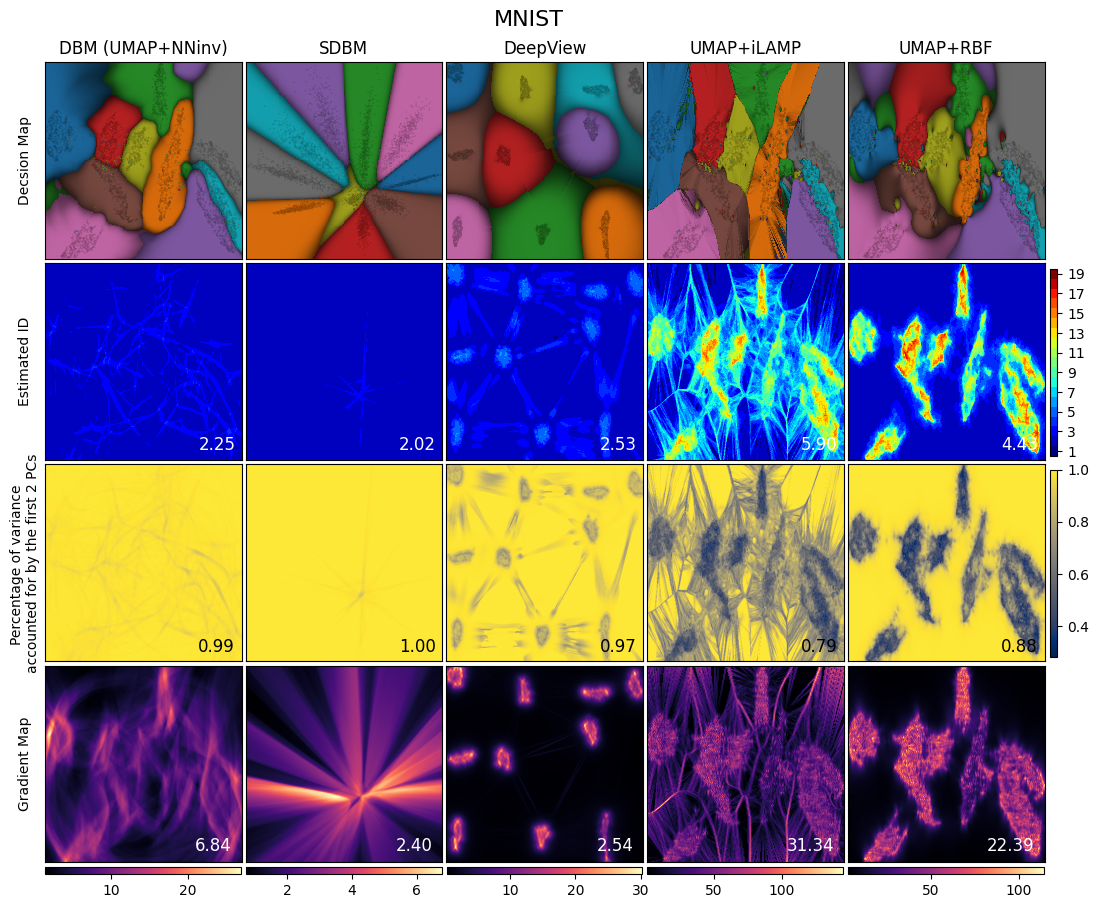

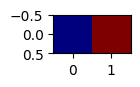

In [20]:
path = './LID_results_new_grid500_GM/mnist_'
test = plot_LID2(path, threshold=threshold, title='MNIST', mode1=mode)
# plt.tight_layout()
# test.savefig('figures/mnist_minimal_var.png', dpi=300, bbox_inches='tight')
# test.savefig('../paper/PAPER_intrinsic_dim/figures/mnist_id.pdf', dpi=300, bbox_inches='tight')
if save:
    test.savefig('../paper/IVAPP24_extend_CCIS/figures/figure_CCIS/mnist_id_5cols.png', dpi=300, bbox_inches='tight')
    



tensor([[7.6485e-01, 2.3391e-01, 7.2681e-04,  ..., 2.3318e-10, 2.3318e-10,
         2.3318e-10],
        [7.5746e-01, 2.4131e-01, 7.9388e-04,  ..., 2.3349e-10, 2.3349e-10,
         2.3349e-10],
        [7.6864e-01, 2.3015e-01, 7.9782e-04,  ..., 2.2671e-10, 2.2671e-10,
         2.2671e-10],
        ...,
        [7.0082e-01, 2.9881e-01, 2.7260e-04,  ..., 1.8976e-10, 1.8976e-10,
         1.8976e-10],
        [6.7028e-01, 3.2934e-01, 2.8547e-04,  ..., 1.9349e-10, 1.9349e-10,
         1.9349e-10],
        [6.9289e-01, 3.0666e-01, 3.4674e-04,  ..., 1.8776e-10, 1.8776e-10,
         1.8776e-10]], dtype=torch.float64)
tensor([[6.7620e-01, 3.1379e-01, 9.1305e-03,  ..., 4.9287e-10, 4.9287e-10,
         4.9287e-10],
        [6.9961e-01, 2.8906e-01, 1.0435e-02,  ..., 4.7932e-10, 4.7932e-10,
         4.7932e-10],
        [7.0285e-01, 2.8585e-01, 1.0406e-02,  ..., 4.7794e-10, 4.7794e-10,
         4.7794e-10],
        ...,
        [6.8779e-01, 3.1203e-01, 4.9795e-05,  ..., 1.0523e-09, 1.0523e-09,
    

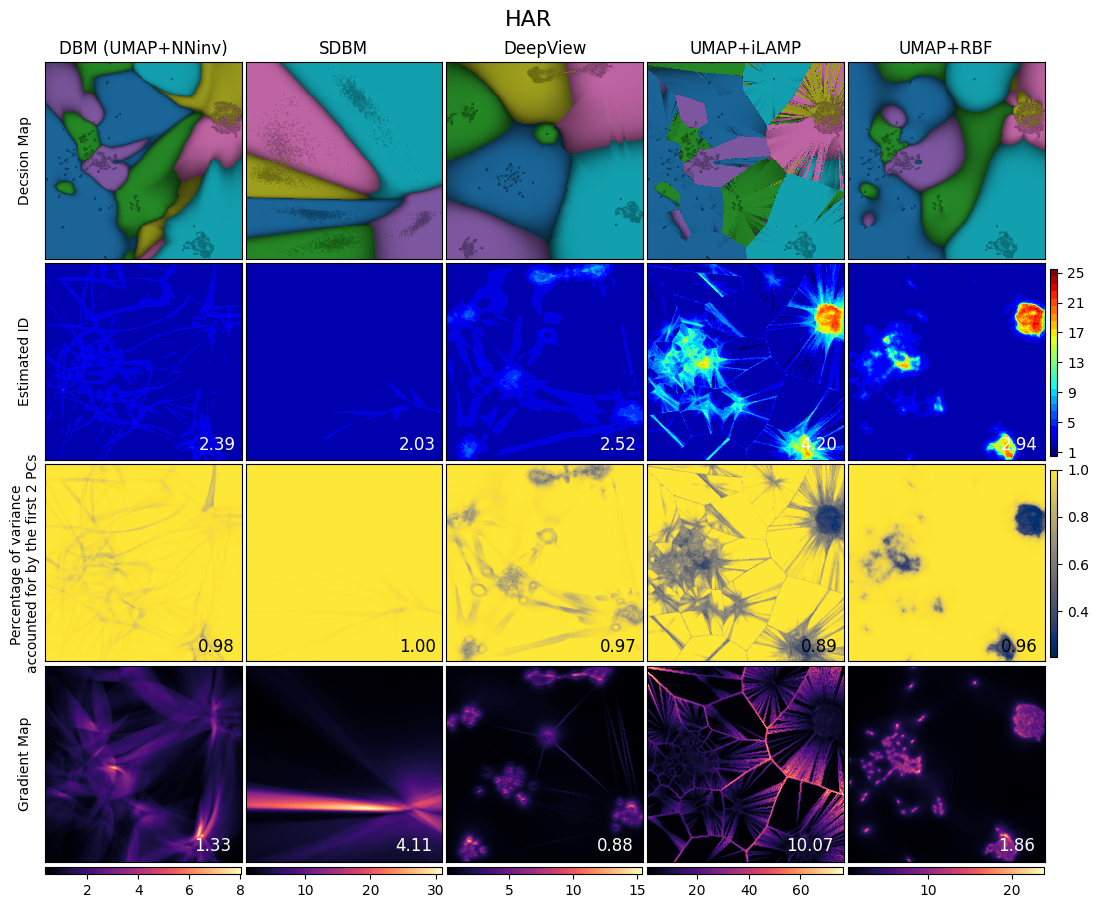

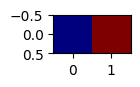

In [21]:
dim5 = plot_LID2('./LID_results_new_grid500_GM/har_', threshold=threshold, title='HAR', mode1=mode)
# dim5.savefig('./figures/har_500bad.png', dpi=300, bbox_inches='tight')
# dim5.savefig('../paper/PAPER_intrinsic_dim/figures/har_id.pdf', dpi=300, bbox_inches='tight')
if save:
    dim5.savefig('../paper/IVAPP24_extend_CCIS/figures/figure_CCIS/har_id_5cols.png', dpi=300, bbox_inches='tight')

In [22]:
## make the above 5 into a list 



### OLD

In [28]:
dim50 = plot_LID('./LID_results/blobs_dim50_n1000_', threshold=0.99, title='50D Blobs')
dim50.savefig('./figures/blobs_dim50_n1000_.png', dpi=300, bbox_inches='tight')

NameError: name 'plot_LID' is not defined

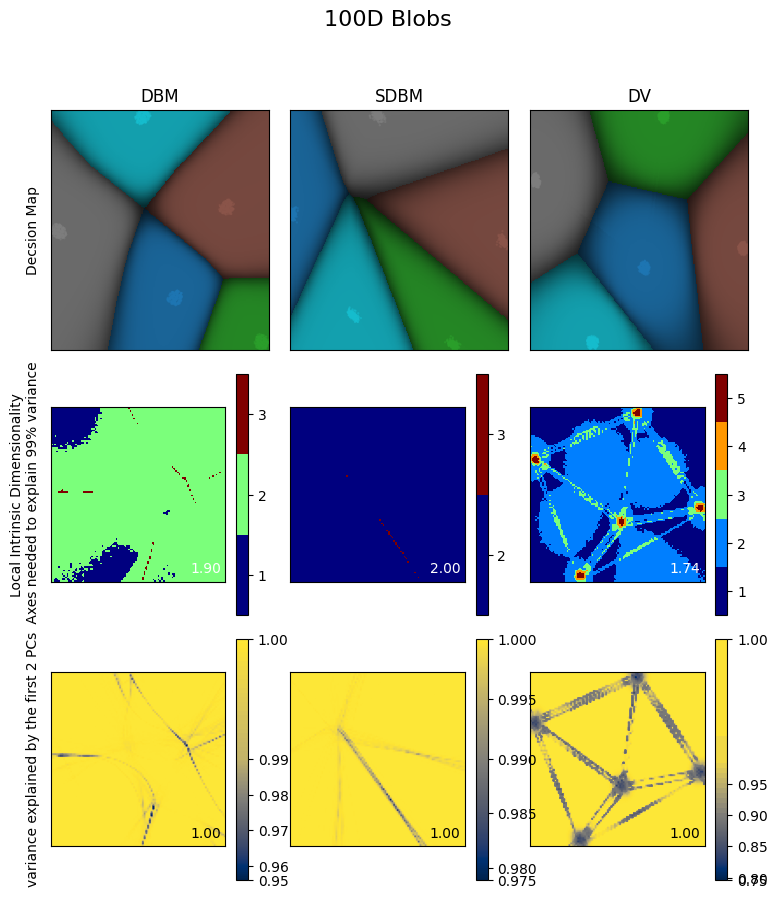

In [ ]:
dim100 = plot_LID('./LID_results/blobs_dim100_n1000_', threshold=0.99, title='100D Blobs')
dim100.savefig('./figures/blobs_dim100_n1000_.png', dpi=300)

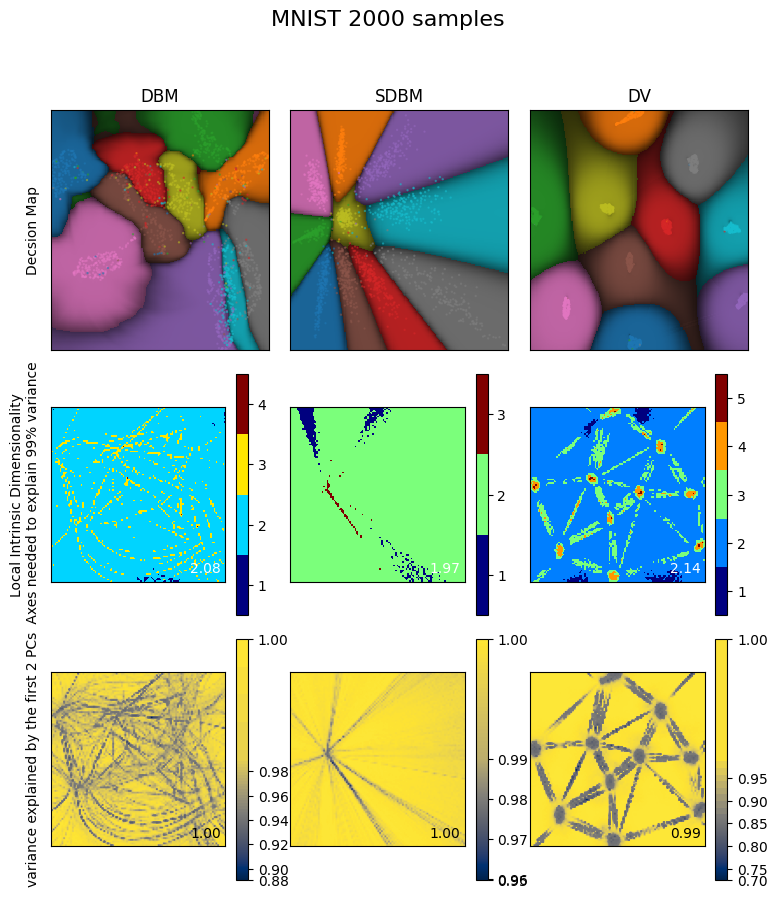

In [ ]:
mnist = plot_LID('./LID_results/mnist_', threshold=0.99, title='MNIST 2000 samples')
mnist.savefig('./figures/mnist.png', dpi=300)

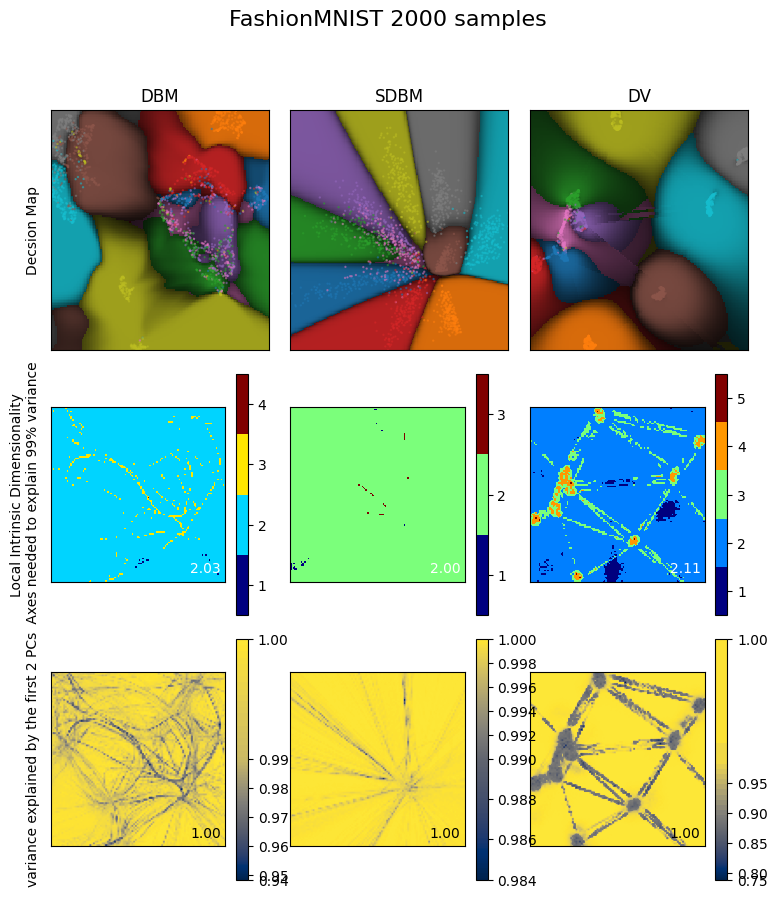

In [ ]:
mnist = plot_LID('./LID_results/fashionmnist_', threshold=0.99, title='FashionMNIST 2000 samples')
mnist.savefig('./figures/fashionmnist.png', dpi=300)

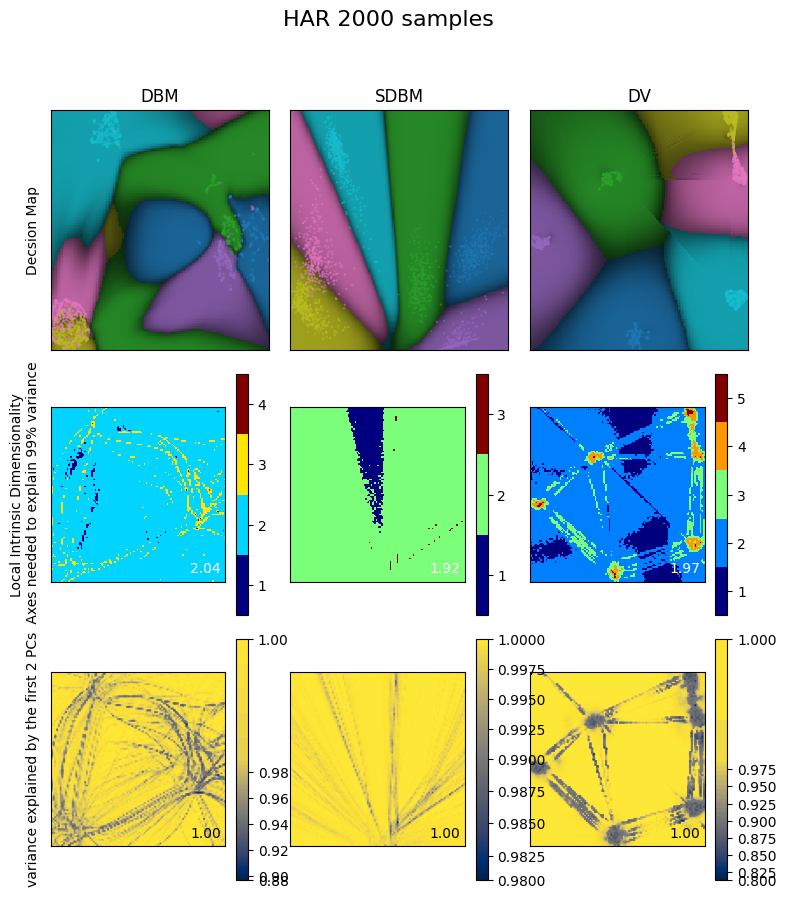

In [ ]:
mnist = plot_LID('./LID_results/har_', threshold=0.99, title='HAR 2000 samples')
mnist.savefig('./figures/har.png', dpi=300)